/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_21840/1330899212.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EXAMDT'] = pd.to_datetime(df['EXAMDT'], errors='coerce')


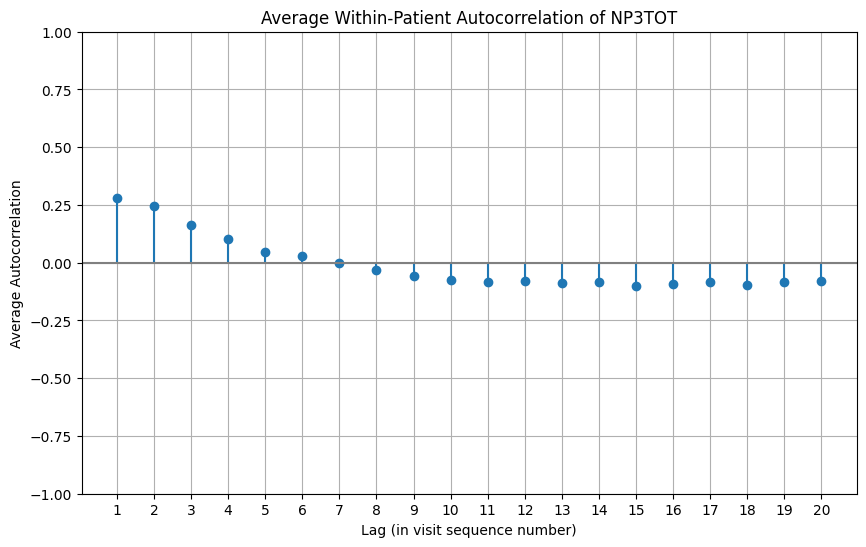

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import numpy as np

# Load your CSV
df = pd.read_csv('/Users/larsheijnen/Thesis/data/MDS-UPDRS_Part_III_21Mar2025.csv')

# Parse dates
df['EXAMDT'] = pd.to_datetime(df['EXAMDT'], errors='coerce')

# Filter out rows with missing dates or NP3TOT values
df = df.dropna(subset=['EXAMDT', 'NP3TOT'])

# Ensure NP3TOT is numeric
df['NP3TOT'] = pd.to_numeric(df['NP3TOT'], errors='coerce')

# Drop rows with missing NP3TOT values after conversion
df = df.dropna(subset=['NP3TOT'])


# Group by patient and calculate ACF for each
all_acf_values = []
max_lags = 20 # Choose a reasonable maximum lag based on expected visit frequency
patients = df['PATNO'].unique()

for patient in patients:
    patient_df = df[df['PATNO'] == patient].sort_values('EXAMDT')

    # Need at least a few observations and lags+1 points to calculate ACF
    if len(patient_df) > max_lags + 1 : # Ensure enough data points for requested lags
        # Calculate ACF using statsmodels function.
        # nlags adjusts automatically if series is too short, but good to check.
        # Use fft=False for potentially more stable calculation with missing lags
        try:
             # acf returns values including lag 0 (which is always 1)
            acf_vals = acf(patient_df['NP3TOT'], nlags=max_lags, fft=False)
            # Pad with NaN if fewer lags were computed than requested due to short series
            padded_acf = np.pad(acf_vals, (0, max_lags + 1 - len(acf_vals)), 'constant', constant_values=np.nan)
            all_acf_values.append(padded_acf)
        except Exception as e:
            print(f"Could not compute ACF for patient {patient}: {e}")
            # Append NaNs if calculation fails
            all_acf_values.append(np.full(max_lags + 1, np.nan))
    else:
         # Append NaNs if not enough data
         all_acf_values.append(np.full(max_lags + 1, np.nan))


# Average the ACF values across patients (ignoring NaNs)
# Ensure we have some valid ACF results before averaging
if all_acf_values:
    acf_array = np.array(all_acf_values)
    # Calculate mean ignoring NaNs for each lag
    # Need to handle cases where a lag column might be all NaN
    with np.errstate(invalid='ignore'): # Suppress warning for mean of empty slice
         avg_acf = np.nanmean(acf_array, axis=0)
else:
    avg_acf = np.array([np.nan] * (max_lags + 1)) # Or handle as appropriate

# Plot the average ACF (excluding lag 0)
if len(avg_acf) > 1:
    lags_to_plot = np.arange(1, max_lags + 1)
    acf_to_plot = avg_acf[1:] # Exclude lag 0

    # Filter out NaNs that might result if ALL patients had NaN for a specific lag
    valid_indices = ~np.isnan(acf_to_plot)
    lags_to_plot = lags_to_plot[valid_indices]
    acf_to_plot = acf_to_plot[valid_indices]

    if len(acf_to_plot) > 0:
        plt.figure(figsize=(10, 6))
        plt.stem(lags_to_plot, acf_to_plot, basefmt=" ") # Use stem plot for clarity
        plt.axhline(y=0, linestyle='-', color='gray')
        # Add approximate confidence intervals (less formal than plot_acf's)
        # Approximate standard error is 1/sqrt(N), but N varies per patient.
        # This is a very rough guide; formal inference is complex here.
        # conf_level = 1.96 / np.sqrt(len(df)) # Very rough global estimate
        # plt.axhline(y=conf_level, linestyle='--', color='blue')
        # plt.axhline(y=-conf_level, linestyle='--', color='blue')
        plt.title('Average Within-Patient Autocorrelation of NP3TOT')
        plt.xlabel('Lag (in visit sequence number)')
        plt.ylabel('Average Autocorrelation')
        plt.ylim([-1, 1])
        plt.xticks(lags_to_plot)
        plt.grid(True)
        plt.show()
    else:
        print("No valid average ACF values to plot (excluding lag 0).")
else:
    print("Could not calculate average ACF.")

In [3]:
# Create a DataFrame to store lagged values and their average autocorrelations
if len(avg_acf) > 1:
    lagged_values_df = pd.DataFrame({
        'Lag': np.arange(1, max_lags + 1),
        'Average_ACF': avg_acf[1:]  # Exclude lag 0
    })

    # Drop rows with NaN values (if any)
    lagged_values_df = lagged_values_df.dropna()

    # Display the DataFrame
    print(lagged_values_df)
else:
    print("No valid average ACF values to return.")

    Lag  Average_ACF
0     1     0.279615
1     2     0.245633
2     3     0.164072
3     4     0.102437
4     5     0.047567
5     6     0.028645
6     7     0.000479
7     8    -0.030153
8     9    -0.057631
9    10    -0.074514
10   11    -0.084489
11   12    -0.081149
12   13    -0.089503
13   14    -0.084473
14   15    -0.099101
15   16    -0.091979
16   17    -0.081926
17   18    -0.096113
18   19    -0.085245
19   20    -0.077232
